# Лабораторная работа 8

## Преобразование Гильберта-Хуанга

## Задачи и порядок выполнения работы

1. Получить массив отсчётов исходного сигнала из заранее подготовленного звукового WAV-файла с записанным ЛЧМ-сигналом с девиацией частоты от $f_0$ до $f_1$ длительностью 8−15 с.
2. Построить графики звукового сигнала во временной и частотной области.
3. Построить спектрограмму сигнала.
4. Выполнить эмпирическую модовую декомпозицию сигнала.
5. Построить графики эмпирических модовых функций.
6. Построить график зависимости частоты сигнала от времени. Сравнить полученный график со спектрограммой.

#### 1. Получить массив отсчётов исходного сигнала из заранее подготовленного звукового WAV-файла с записанным ЛЧМ-сигналом с девиацией частоты от $f_0$ до $f_1$ длительностью 8−15 с.

In [1]:
chirp_freq_base = 50.0
'Несущая частота ЛЧМ сигнала, Гц'
chirp_freq_start = 300.0
'Начальная частота ЛЧМ сигнала, Гц'
chirp_freq_end = 650.0
'Конечная частота ЛЧМ сигнала, Гц'
chirp_duration = 10.0
'Продолжительность ЛЧМ сигнала, с'
chirp_amp_base = 0.2
'Амплитуда несущей частоты ЛЧМ сигнала'
chirp_amp_freqs = 0.4
'Амплитуда переменной частоты ЛЧМ сигнала'

print('Задаем параметры ЛЧМ сигнала')

Задаем параметры ЛЧМ сигнала


In [2]:
import numpy as np
from soundfile import write
from IPython.display import Audio

sampling_rate = 22050

chirp_length = int(chirp_duration * sampling_rate)
chirp_time = np.arange(chirp_length) / sampling_rate

chirp_base_signal = chirp_amp_base * np.sin(2.0 * np.pi * chirp_freq_base * chirp_time)
chirp_freqs = np.linspace(chirp_freq_start, chirp_freq_end, chirp_length)
chirp_freqs_signal = chirp_amp_freqs * np.sin(2.0 * np.pi * chirp_freqs * chirp_time)

chirp_signal = chirp_base_signal + chirp_freqs_signal
print('Формируем ЛЧМ сигнал')
write('chirp.wav', chirp_signal, samplerate=sampling_rate)

Audio('chirp.wav')

Формируем ЛЧМ сигнал


#### 2. Построить графики звукового сигнала во временной и частотной области.

Text(0.5, 0, 'Время, с')

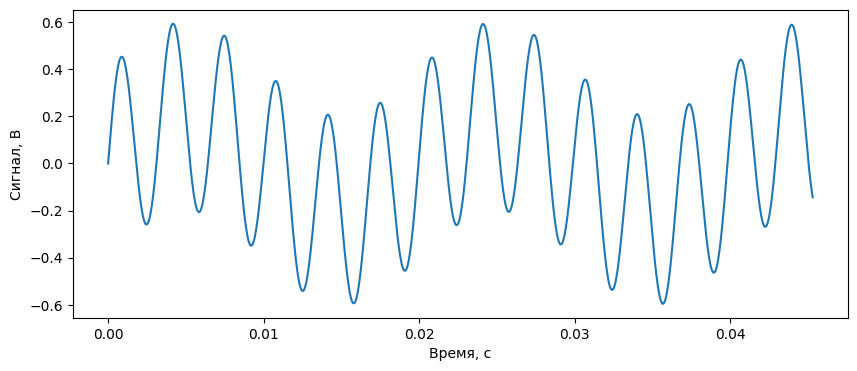

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(chirp_time[:1000], chirp_signal[:1000])
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

Text(0.5, 0, 'Время, с')

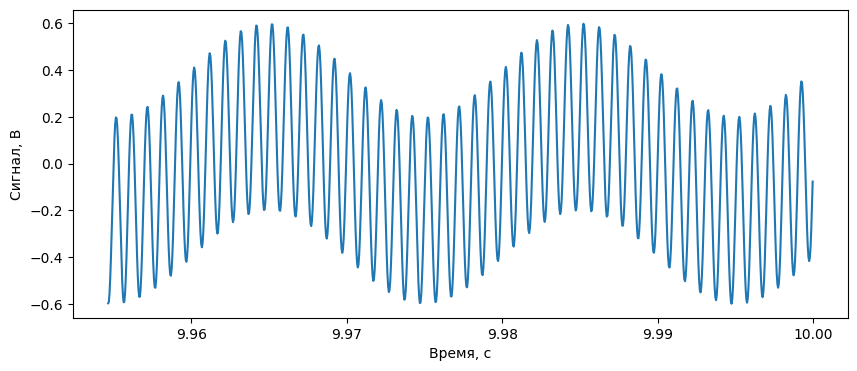

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(chirp_time[-1000:], chirp_signal[-1000:])
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

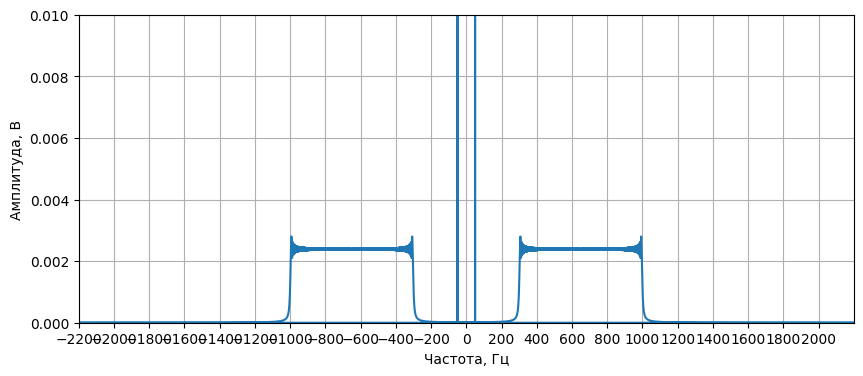

In [5]:
from scipy.fft import fft, fftfreq

def freq_plot(data: np.ndarray):
    sp = fft(data)
    length = len(data)
    freq = fftfreq(length, 1 / sampling_rate)
    plt.figure(figsize=(10, 4))
    plt.plot(freq, np.abs(sp / length))
    plt.xlim(-2200.0, 2200.0)
    plt.ylim(0.00, 0.01)
    plt.xticks(np.arange(-2200.0, 2200.0, 200.0))
    plt.grid()
    plt.xlabel('Частота, Гц')
    plt.ylabel('Амплитуда, В')

freq_plot(chirp_signal)

#### 3. Построить спектрограмму сигнала.

Text(0.5, 0, 'Время, с')

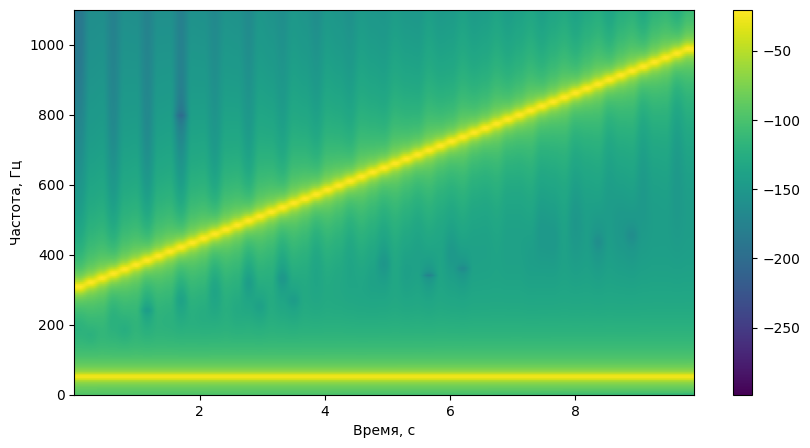

In [6]:
plt.figure(figsize=(10, 5))
plt.specgram(chirp_signal, NFFT=4096, Fs=sampling_rate, scale='dB')
plt.ylim(0.0, 1100.0)
plt.colorbar()
plt.ylabel('Частота, Гц')
plt.xlabel('Время, с')

#### 4. Выполнить эмпирическую модовую декомпозицию сигнала.

Text(0.5, 0, 'Время, с')

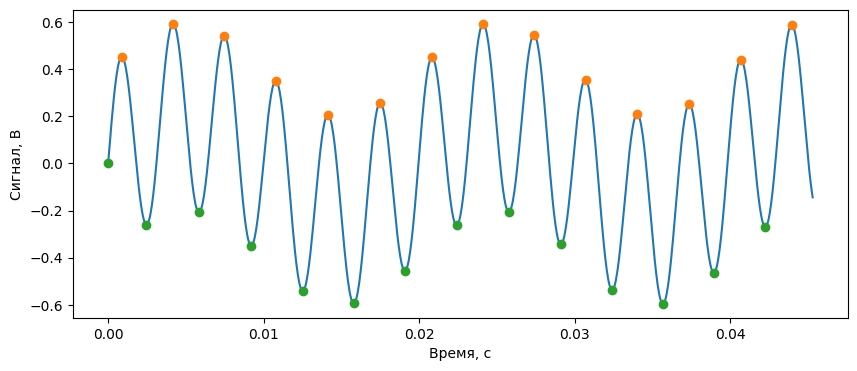

In [7]:
def find_peaks(time, signal):
    signal_shifted_right = np.roll(signal, 1)
    signal_shifted_left = np.roll(signal, -1)

    signal_shifted_right[0] = -np.inf
    signal_shifted_left[-1] = -np.inf
    is_local_maximum = np.logical_and(
        signal > signal_shifted_left,
        signal > signal_shifted_right,
    )
    maximum_x = time[is_local_maximum]
    maximum_y = signal[is_local_maximum]

    signal_shifted_right[0] = np.inf
    signal_shifted_left[-1] = np.inf
    is_local_minimum = np.logical_and(
        signal < signal_shifted_left,
        signal < signal_shifted_right,
    )
    minimum_x = time[is_local_minimum]
    minimum_y = signal[is_local_minimum]

    return minimum_x, minimum_y, maximum_x, maximum_y

minimum_x, minimum_y, maximum_x, maximum_y = find_peaks(chirp_time, chirp_signal)
plt.figure(figsize=(10, 4))
plt.plot(chirp_time[:1000], chirp_signal[:1000])
plt.plot(maximum_x[:14], maximum_y[:14], 'o')
plt.plot(minimum_x[:14], minimum_y[:14], 'o')
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

Text(0.5, 0, 'Время, с')

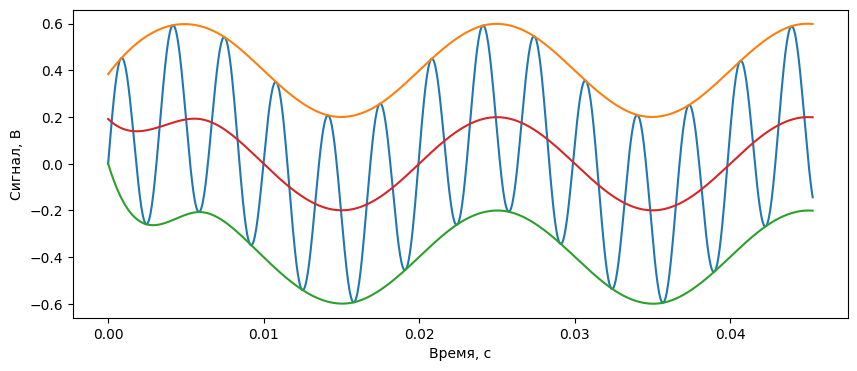

In [8]:
from scipy.interpolate import CubicSpline

def find_splines(time, signal):
    minimum_x, minimum_y, maximum_x, maximum_y = find_peaks(time, signal)
    maximum_cs = CubicSpline(maximum_x, maximum_y)(time)
    minimum_cs = CubicSpline(minimum_x, minimum_y)(time)
    peaks_mean = np.mean((minimum_cs, maximum_cs), axis=0)
    
    return minimum_cs, maximum_cs, peaks_mean
 
minimum_cs, maximum_cs, peaks_mean = find_splines(chirp_time, chirp_signal)
plt.figure(figsize=(10, 4))
plt.plot(chirp_time[:1000], chirp_signal[:1000])
plt.plot(chirp_time[:1000], maximum_cs[:1000])
plt.plot(chirp_time[:1000], minimum_cs[:1000])
plt.plot(chirp_time[:1000], peaks_mean[:1000])
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

In [9]:
epsilon = 1e-4

def delta(current_h, new_h):
    return np.sum((current_h - new_h) ** 2) / np.sum(current_h ** 2)

def find_mode(time, signal):
    current_h = signal
    while True:
        _, _, peaks_mean = find_splines(time, current_h)
        new_h = current_h - peaks_mean
        if delta(current_h, new_h) < epsilon:
            return new_h
        current_h = new_h

def power(signal):
    return np.average(signal ** 2)

def find_modes(time, signal):
    modes = []
    signal_left = signal
    while True:
        mode = find_mode(time, signal_left)
        modes.append(mode)
        signal_left = signal_left - mode
        if power(signal_left) < epsilon:
            return modes

modes = find_modes(chirp_time, chirp_signal)


In [10]:
from scipy.signal import hilbert

def find_freq(time, signal):
    hx = hilbert(signal)
    'Преобразование Гильберта переводит сигнал в комплексную плоскость'
    phi = np.angle(hx)
    'Извлекаем из комплексного сигнала угол'
    cont_phi = np.unwrap(phi)
    '"Разворачиваем" значения угла из области [-pi, pi] в монотонную функцию'

    phi_approx = np.polyfit(time, cont_phi / 2.0 / np.pi, 3)
    'Аппроксимируем угол полиномом 3 степени'
    phi_deriv = np.polyder(phi_approx)
    'Находим производную аппроксимации угла'
    freq = np.polyval(phi_deriv, time)
    'Частота - это значения производной в различные моменты времени'
    return freq

mode_freqs = [find_freq(chirp_time, mode) for mode in modes]

#### 5. Построить графики эмпирических модовых функций.

Text(0.5, 0, 'Время, с')

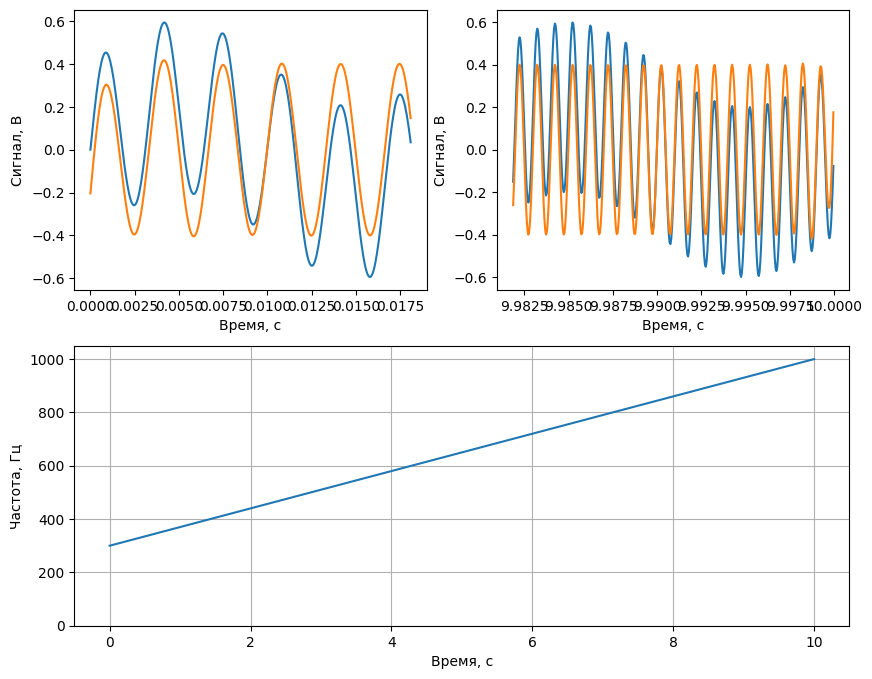

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.plot(chirp_time[:400], chirp_signal[:400])
plt.plot(chirp_time[:400], modes[0][:400])
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

plt.subplot(222)
plt.plot(chirp_time[-400:], chirp_signal[-400:])
plt.plot(chirp_time[-400:], modes[0][-400:])
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

plt.subplot(2, 2, (3, 4))
plt.grid()
plt.ylim(0.0, 1050.0)
plt.plot(chirp_time, mode_freqs[0])
plt.ylabel('Частота, Гц')
plt.xlabel('Время, с')


Text(0.5, 0, 'Время, с')

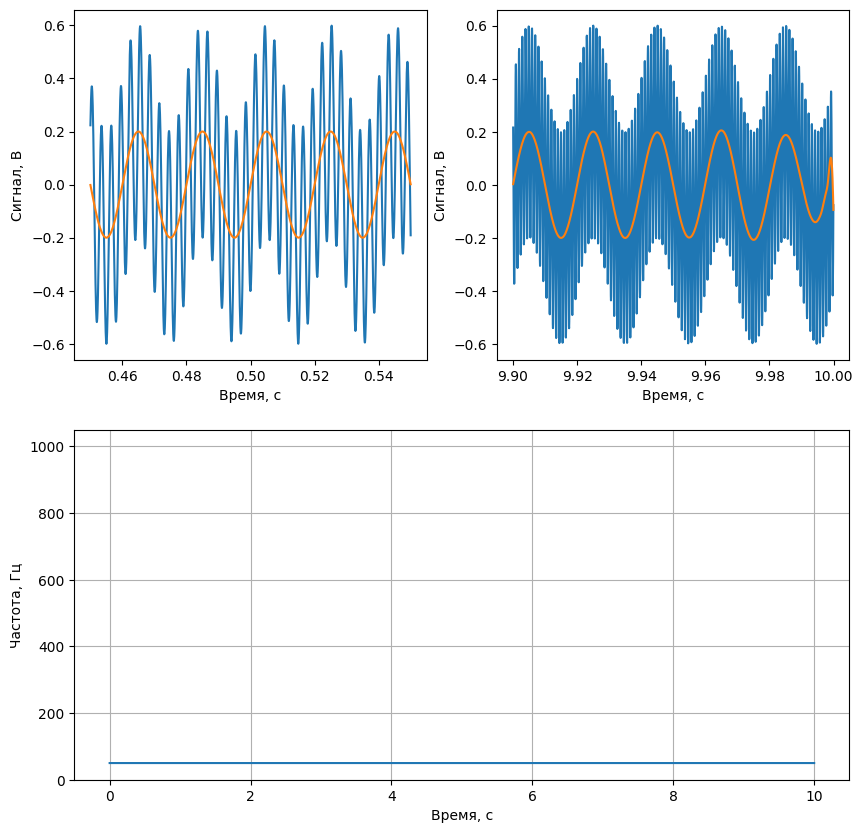

In [12]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
subrange = np.logical_and(0.45 < chirp_time, chirp_time < 0.55)
plt.plot(chirp_time[subrange], chirp_signal[subrange])
plt.plot(chirp_time[subrange], modes[1][subrange])
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

plt.subplot(222)
plt.plot(chirp_time[9.90 < chirp_time], chirp_signal[9.90 < chirp_time])
plt.plot(chirp_time[9.90 < chirp_time], modes[1][9.90 < chirp_time])
plt.ylabel('Сигнал, В')
plt.xlabel('Время, с')

plt.subplot(2, 2, (3, 4))
plt.grid()
plt.ylim(0.0, 1050.0)
plt.plot(chirp_time, mode_freqs[1])
plt.ylabel('Частота, Гц')
plt.xlabel('Время, с')

#### 6. Построить график зависимости частоты сигнала от времени. Сравнить полученный график со спектрограммой.

Text(0.5, 0, 'Время, с')

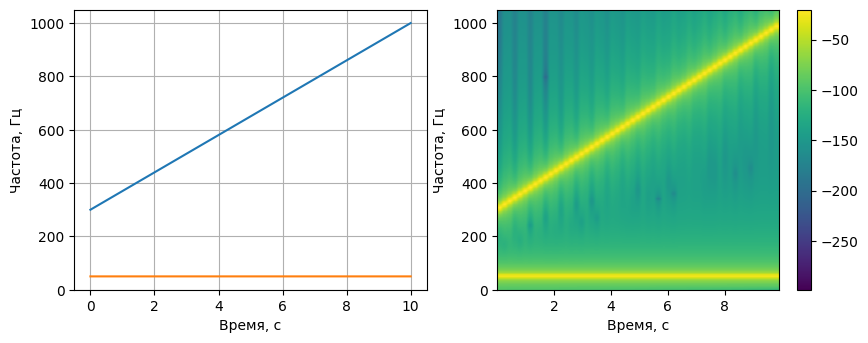

In [13]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.grid()
plt.ylim(0.0, 1050.0)
plt.plot(chirp_time, mode_freqs[0])
plt.plot(chirp_time, mode_freqs[1])
plt.ylabel('Частота, Гц')
plt.xlabel('Время, с')

plt.subplot(222)
plt.specgram(chirp_signal, NFFT=4096, Fs=sampling_rate, scale='dB')
plt.ylim(0.0, 1050.0)
plt.colorbar()
plt.ylabel('Частота, Гц')
plt.xlabel('Время, с')

## Контрольные вопросы

#### 1. Чем отличаются области применения преобразования Фурье и преобразования Гильберта-Хуанга?

В отличие от преобразования Фурье, а также подобных преобразований, использующих определенный базис, преобразование Гильберта-Хуанга не требует определенного аналитическим образом базиса и может применяться для нестационарных и нелинейных данных.

#### 2. Приведите аналитическое выражение для преобразования Гильберта-Хуанга.

Преобразование Гильберта:

$$ x_j(t) = H[c_j(t)] = c_j(t) * \frac{1}{\pi t} = \frac{1}{\pi} \int_{-\infty}^{\infty}{\frac{c_j(\tau)}{t - \tau} d\tau} $$

#### 3. Что такое эмпирическая модовая декомпозиция и для чего она нужна?

Базисные функции
являются адаптивными и носят название эмпирических мод, а процесс их получе-
ния, предложенный Хуангом, называется эмпирической модовой декомпозицией
(Empirical Mode Decomposition, EMD)

#### 4. Опишите алгоритм получения эмпирических модовых функций.

1. $ i = 0, h_i(k) = y(k) $
2. Найти локальные экстремумы функции $ h_i(k) $
3. Найти огибающие с помощью интерполяции кубическим сплайном (или другим методом) точек локальных экстремумов $ u_i^t(k) $ и $ u_i^b(k) $
4. Вычислить функцию среднюю между огибающими:
$$ m_i(k) = \frac{u_i^t(k) + u_i^b(k)}{2} $$
5. Найти следующую функцию
$$ h_{i+1}(k) = h_i(k) - m_i(k) $$
6. Вычислить дельту
$$ \delta = \frac{\sum_{k}{ |h_i(k) - h_{i + 1}(k)|^2}} {\sum_{k}{h_i^2(k)}} $$
7. Если $ \delta > \epsilon $ : $ i = i + 1 $, вернуться к шагу 2
8. Последняя $ h_i(k) $ есть одна из мод, теперь записываем
$$ y(k) = y(k) - h_i(k) $$
9. Если в $ y(k) $ еще что-то осталось, вернуться к шагу 1

#### 5. Каким выражением определяется мгновенная частота при использовании преобразования Гильберта-Хуанга?

Мгновенная частота может быть определена как первая производная от мгновенной фазы

$$ f(t) = \varphi'(t) $$
